## Procrustes analysis:

## results so far:
### gemma-2b VS gemma-7b

**Whitened 2b -> Whitened 7b**

bad
```
Disparity: ~0.8
```

### gemma-2b VS gemma-2b-it
**Whitened 2b VS Whitened 2b-it.**

Works badly
```
Disparity: ~0.8 
```

**Raw 2b VS Raw 2b (self)**

good, 1e-20 (expected since is self)
```
Disparity: 1.4625364391155197e-27
Frobenius norm of the difference: 3.8243122768878133e-14
Mean absolute difference: 3.2582223475102413e-15
Root MSE: 1.2057898566414926e-16
```
**Raw 2b VS Raw 2b-it**

Good, like 
```
Disparity: 0.21740804394579713
Frobenius norm of the difference: 0.4662703549935354
Mean absolute difference: 0.039223958303363386
Root MSE: 0.0014701311603176892
```

**Linear Regression 2b->it VS Raw 2b-it**

V good, 
```
Disparity: 0.058753351144308956
Frobenius norm of the difference: 0.2423909056551189
Mean absolute difference: 0.025344203382208608
Root MSE: 0.0007642485085421234
```


In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
import torch
from welford_torch import OnlineCovariance
from taker import Model
from taker.texts import prepare

g2 = Model("google/gemma-2b", dtype="hqq4", device_map="cuda", limit=1000)
g7 = Model("google/gemma-2b-it", dtype="hqq4", device_map="cuda", limit=1000)

g2_layer = 9
g7_layer = 9 # 14
# g7 = Model("google/gemma-7b", dtype="hqq4", device_map="cuda", limit=1000)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded model 'google/gemma-2b' with hqq4:
- Added 288 hooks across 18 layers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded model 'google/gemma-2b-it' with hqq4:
- Added 288 hooks across 18 layers


In [2]:
dataset, label, _ = prepare("pile")
for data in dataset:
    text = data[label]
    break

In [3]:
def collect_decoder_layer(m, text, layer):
    m.hooks.disable_all_collect_hooks()
    m.hooks.enable_collect_hooks(["post_decoder"], layers=[layer])
    _outputs_embeds = m.get_outputs_embeds(text)
    state = m.hooks["post_decoder"]["collect"][layer]
    return state

In [4]:
with torch.no_grad():
    state2 = collect_decoder_layer(g2, text, layer=g2_layer)
    state7 = collect_decoder_layer(g7, text, layer=g7_layer)
print(state2.shape)
print(state7.shape)

torch.Size([1, 1000, 2048])
torch.Size([1, 1000, 2048])


In [5]:
cov2 = OnlineCovariance()
cov7 = OnlineCovariance()

sample_size = 1e5
with torch.no_grad():
    for data in tqdm(dataset):
        text = data[label]
        state2 = collect_decoder_layer(g2, text, layer=g2_layer)
        state7 = collect_decoder_layer(g7, text, layer=g7_layer)
        cov2.add_all(state2[0])
        cov7.add_all(state7[0])
        if cov2.count > sample_size:
            break

193it [00:59,  3.23it/s]


In [6]:
whit2 = cov2.whit
whit_inv2 = cov2.whit_inv

whit7 = cov7.whit
whit_inv7 = cov7.whit_inv

In [7]:
def whiten2(x):
    x = x - cov2.mean
    x = torch.nn.functional.linear(x, whit2)
    return x

def whiten7(x):
    x = x - cov7.mean
    x = torch.nn.functional.linear(x, whit7)
    return x[:g2.cfg.d_model]

In [8]:
states2 = []
states7 = []

count = 0
sample_size = 1e5
with torch.no_grad():
    for data in tqdm(dataset):
        text = data[label]
        state2 = collect_decoder_layer(g2, text, layer=g2_layer)
        state7 = collect_decoder_layer(g7, text, layer=g7_layer)
        states2.append(state2[0].cpu())
        states7.append(state7[0].cpu())
        if count == 0:
            print(state2.shape[1])
        count += state2.shape[1]
        if count > sample_size:
            break

1it [00:00,  1.23it/s]

1000


193it [01:02,  3.11it/s]


In [9]:
with torch.no_grad():
    states2 = torch.cat(states2, dim=0)
    states7 = torch.cat(states7, dim=0)

In [10]:
s2 = states2.to(torch.float16).numpy()
s7 = states7.to(torch.float16).numpy()

In [11]:
print(s2.shape, s7.shape)

(100592, 2048) (100592, 2048)


In [19]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(s2, s7)
s2_transformed = reg.predict(s2)

/workspace/nicky/taker/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:522: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)


In [ ]:
# def linear_regression_closed_form(X, y):
#     # Ensure inputs are on GPU if available
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     X = X.to(device)
#     y = y.to(device)

#     # Add a column of ones to X for the intercept term
#     X_with_intercept = torch.cat([torch.ones(X.shape[0], 1, device=device), X], dim=1)

#     # Compute (X^T X)^(-1) X^T y
#     XTX = torch.matmul(X_with_intercept.T, X_with_intercept)
#     XTX_inv = torch.linalg.inv(XTX)
#     XTy = torch.matmul(X_with_intercept.T, y)
#     beta = torch.matmul(XTX_inv, XTy)

#     return beta

# # Example usage:
# # Assuming X and y are your input data and target variables
# X = torch.randn(10000, 2048, device="cuda")  # Example input
# y = torch.randn(10000, 2048, device="cuda")  # Example target

# beta = linear_regression_closed_form(X, y)

# # To make predictions:
# X_new = torch.randn(1000, 2048, device="cuda")  # New data to predict
# X_new_with_intercept = torch.cat([torch.ones(X_new.shape[0], 1, device="cuda"), X_new], dim=1)
# predictions = torch.matmul(X_new_with_intercept, beta)


In [20]:

from scipy.spatial import procrustes
mtx1, mtx2, disparity = procrustes(s2_transformed, s7)

print("Disparity:", disparity)
print("Shape of mtx1:", mtx1.shape)
print("Shape of mtx2:", mtx2.shape)

# Calculate and print additional metric
print("Frobenius norm of the difference:", np.linalg.norm(mtx1 - mtx2))
print("Mean absolute difference:", np.mean(np.sum(np.abs(mtx1 - mtx2), axis=-1)))
print("Root MSE:", np.sqrt(np.mean(np.sum((mtx1 - mtx2)**2, axis=-1))))

Disparity: 0.058753351144308956
Shape of mtx1: (100592, 2048)
Shape of mtx2: (100592, 2048)
Frobenius norm of the difference: 0.2423909056551189
Mean absolute difference: 0.025344203382208608
Root MSE: 0.0007642485085421234


In [12]:
from scipy.spatial import procrustes
mtx1, mtx2, disparity = procrustes(s2, s2)

print("Disparity:", disparity)
print("Shape of mtx1:", mtx1.shape)
print("Shape of mtx2:", mtx2.shape)

# Calculate and print additional metric
print("Frobenius norm of the difference:", np.linalg.norm(mtx1 - mtx2))
print("Mean absolute difference:", np.mean(np.sum(np.abs(mtx1 - mtx2), axis=-1)))
print("Root MSE:", np.sqrt(np.mean(np.sum((mtx1 - mtx2)**2, axis=-1))))

Disparity: 1.4625364391155197e-27
Shape of mtx1: (100592, 2048)
Shape of mtx2: (100592, 2048)
Frobenius norm of the difference: 3.8243122768878133e-14
Mean absolute difference: 3.2582223475102413e-15
Root MSE: 1.2057898566414926e-16


In [13]:
from scipy.spatial import procrustes
mtx1, mtx2, disparity = procrustes(s2, s7[:, :2048])

print("Disparity:", disparity)
print("Shape of mtx1:", mtx1.shape)
print("Shape of mtx2:", mtx2.shape)

# Calculate and print additional metrics
print("Frobenius norm of the difference:", np.linalg.norm(mtx1 - mtx2))
print("Mean absolute difference:", np.mean(np.sum(np.abs(mtx1 - mtx2), axis=-1)))
print("Root MSE:", np.sqrt(np.mean(np.sum((mtx1 - mtx2)**2, axis=-1))))

Disparity: 0.21740804394579713
Shape of mtx1: (100592, 2048)
Shape of mtx2: (100592, 2048)
Frobenius norm of the difference: 0.4662703549935354
Mean absolute difference: 0.039223958303363386
Root MSE: 0.0014701311603176892


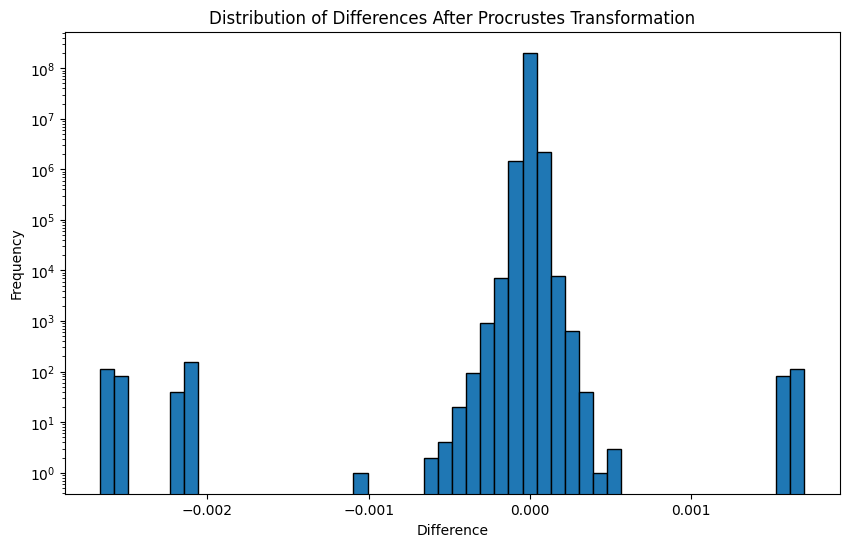

In [27]:
# Visualize the distribution of differences
plt.figure(figsize=(10, 6))
plt.hist((mtx1 - mtx2).flatten(), bins=50, edgecolor='black')
plt.yscale('log')
plt.title("Distribution of Differences After Procrustes Transformation")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.show()


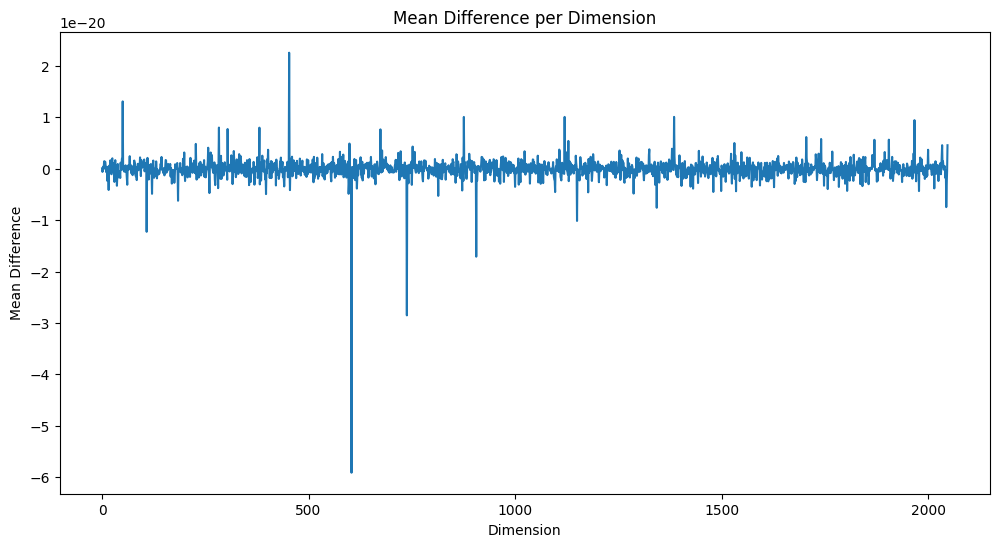

In [22]:
# Visualize mean difference per dimension
mean_diff_per_dim = np.mean(mtx1 - mtx2, axis=0)
plt.figure(figsize=(12, 6))
plt.plot(mean_diff_per_dim)
plt.title("Mean Difference per Dimension")
plt.xlabel("Dimension")
plt.ylabel("Mean Difference")
plt.show()


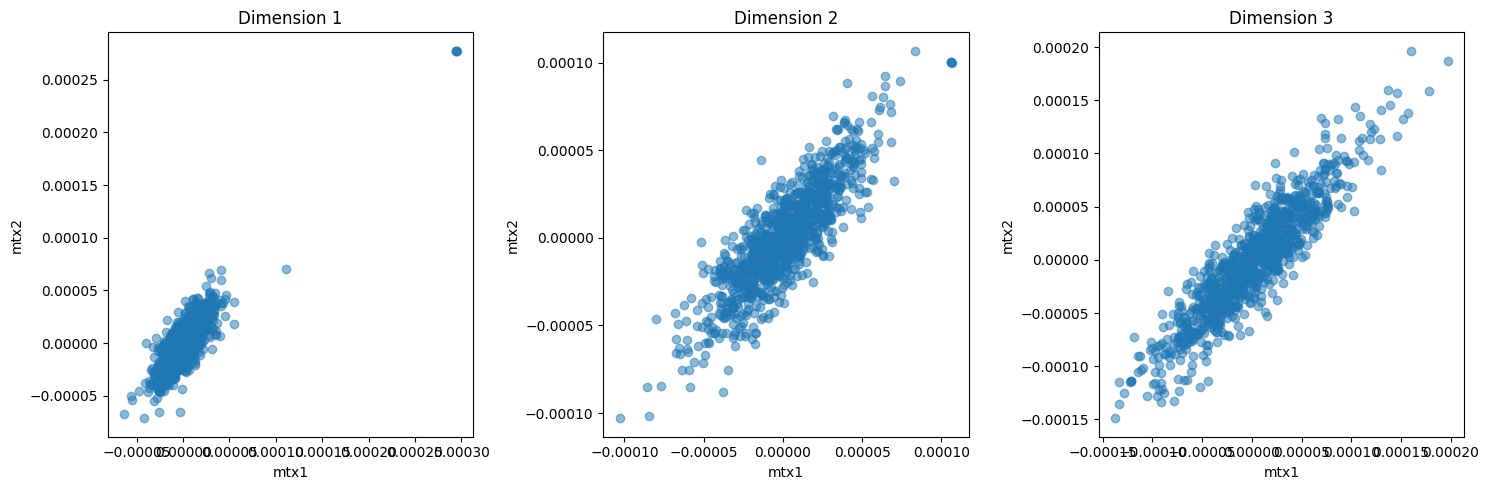

In [23]:
# Visualize alignment of first three dimensions
num_points = 1000  # Adjust as needed
plt.figure(figsize=(15, 5))
for i in range(3):  # Plot first 3 dimensions
    plt.subplot(1, 3, i+1)
    plt.scatter(mtx1[:num_points*100:100, i*100], mtx2[:num_points*100:100, i*100], alpha=0.5)
    plt.title(f"Dimension {i+1}")
    plt.xlabel("mtx1")
    plt.ylabel("mtx2")
plt.tight_layout()
plt.show()


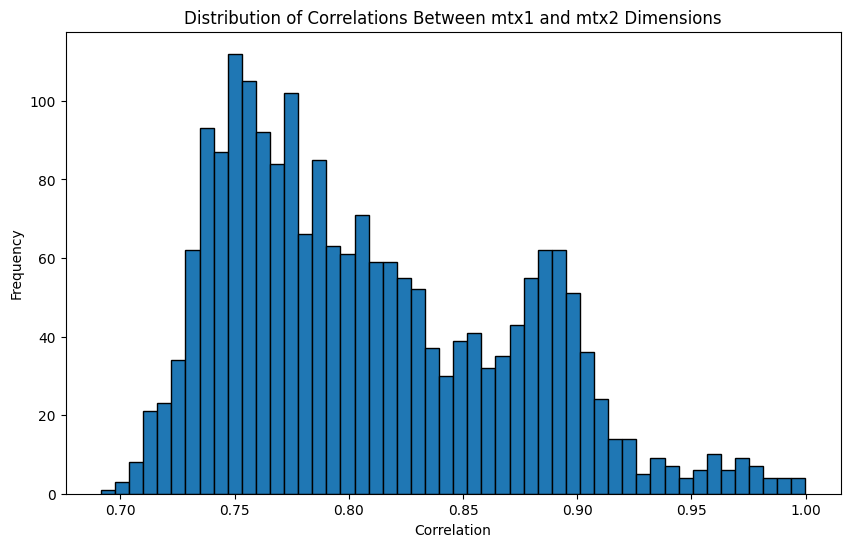

In [24]:
# Compute and visualize correlations
correlations = [np.corrcoef(mtx1[:, i], mtx2[:, i])[0, 1] for i in range(mtx1.shape[1])]
plt.figure(figsize=(10, 6))
plt.hist(correlations, bins=50, edgecolor='black')
plt.title("Distribution of Correlations Between mtx1 and mtx2 Dimensions")
plt.xlabel("Correlation")
plt.ylabel("Frequency")
plt.show()

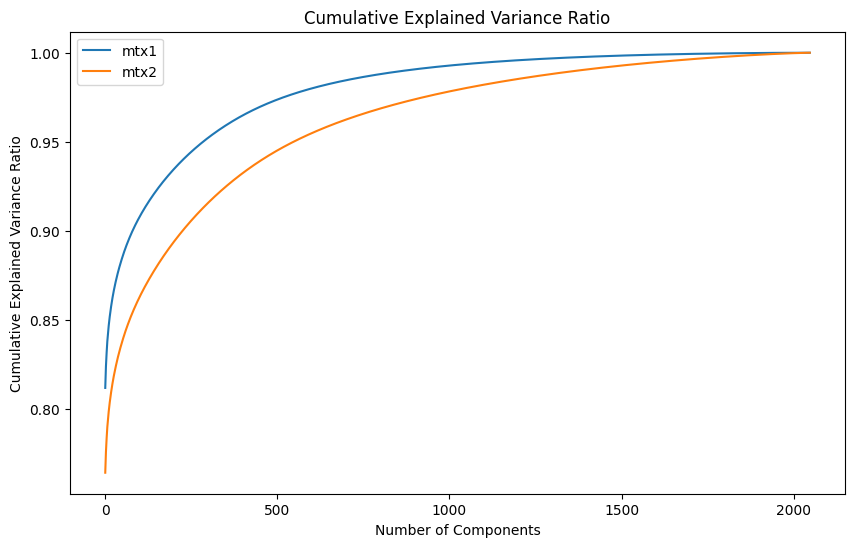

In [25]:
# Perform PCA on both datasets and compare
from sklearn.decomposition import PCA

pca_mtx1 = PCA().fit(mtx1)
pca_mtx2 = PCA().fit(mtx2)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_mtx1.explained_variance_ratio_), label='mtx1')
plt.plot(np.cumsum(pca_mtx2.explained_variance_ratio_), label='mtx2')
plt.title("Cumulative Explained Variance Ratio")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.legend()
plt.show()
